In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
from pyspark import SparkContext, SparkConf
from datetime import datetime as dt
from timeit import timeit
from pyspark.sql import Row


In [3]:
tweetDataFrame = sqlContext.read.json('group_assignment/tweets/tweets_extended.json')
tweetDataFrame.printSchema()

root
 |-- created_at: long (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = tr

In [4]:
"""
PART: Select subset of data and parse dates
"""

"""
HELPER FUNCTIONS FOR cleaning and parsing date
"""
def clean_up_row(row):
    """
    cleans up row and return new row object
    """
    return Row(       
        id=row.id,
        hashtags=row.hashtags,
        hashtags_count = len(row.hashtags),
        text=row.text,
        created_at=convert_long_date(row.created_at),
        )

def convert_long_date(long_date):
    return dt.fromtimestamp(long_date / 1e3)

def convert_date_string(date_string):
    """
    converts e.g. 2015-01-31 12:30:30 +0000
    NOTE: unused currently, but might come handy later..
    """
    if not date_string:
        return None
    return dt.strptime(date_string, '%Y-%m-%d %H:%M:%S +0000')


"""
Execute query
"""
tweet_data_frame = sqlContext.read.json('group_assignment/tweets/tweets_extended.json')
tweets_subset = tweet_data_frame.selectExpr('id', 'created_at','text','entities.hashtags.text as hashtags').rdd
parsed_tweets = tweets_subset.map(clean_up_row)

"""
PART: EXTRACTING THE MMA TWEETS
"""
import re

def filter_mma(row):
    """
    filters mma row
    """
    #variable contains list of meaningful MMA expressions, after cleaning expressions such as
    #u'TOMMARRS', u'DILEMMA', u'SUMMARY', u'MUHAMMAD_WAKAS',u'SUMMARIZING', u'SUMMARIZED' ....
    
    mma_accepted = ['MMA_BLOG', 'SMMMAGAZINE', 'MMA_CRM', 'MMA', 'BIG', 
                    'BIGDATA', 'SASANALYTICS', 'ANALYTICS', 'ANALYSIS', 
                    'RSTATS', 'STATFACT', 'AMSTATNEWS' 'STATISTICIANS', 
                    'STATS', 'STAT', 'STATISTICAL', 'MASTAT', 'DATASCIENCE', 'SCIENTIST'] 
    
    #start matching
    regex_p1 =  r'(\w*%s\w*)' % 'MMA'
    regex_p2 =  r'(\w*%s\w*)' % 'BIG'
    regex_p3 =  r'(\w*%s\w*)' % 'ANALY'
    regex_p4 =  r'(\w*%s\w*)' % 'STAT'
    regex_p5 =  r'(\w*%s\w*)' % 'SCIENTIST'
    regex_p6 =  r'(\w*%s\w*)' % 'DATASCIENCE'
    results = re.findall(regex_p1, row.text.upper()) + re.findall(regex_p2, row.text.upper()) + re.findall(regex_p3, row.text.upper()) + re.findall(regex_p4, row.text.upper()) + re.findall(regex_p5, row.text.upper()) + re.findall(regex_p6, row.text.upper())
    #now see if one of the expression is an 'accepted' expression
    results = [r for r in results if r in mma_accepted]
    
    if len(results) > 0:
        return True
    return False


"""
Execute query
"""
DATA_SCIENCE_tweets = parsed_tweets.filter(filter_mma)


In [5]:
"""
NUMBER OF TWEETS PER DAY
"""
#sort data
DATA_SCIENCE_tweets = DATA_SCIENCE_tweets.sortBy(lambda x: x.created_at) 
#print first data science related tweet 
print DATA_SCIENCE_tweets.take(1)

#print last data science related tweet 
print DATA_SCIENCE_tweets.sortBy(lambda x: x.created_at, ascending=False).take(1)

# collect()[-1] also works

#to return to DF from RDD
new_df = sqlContext.createDataFrame(DATA_SCIENCE_tweets)
#select works again
#print new_df.selectExpr('created_at as bitchin_mother_fucker').take(1)



[Row(created_at=datetime.datetime(2009, 10, 27, 0, 0), hashtags=[u'M2009'], hashtags_count=1, id=5203805716L, text=u'Will Neafsey (Ford Motor Company) at SAS #M2009 is talking about using analytics in difficult economic times... great opportunities')]
[Row(created_at=datetime.datetime(2015, 11, 15, 20, 31, 40), hashtags=[u'Deep', u'SC15', u'MLHPC2015', u'HPC', u'BigData', u'neuralnetworks'], hashtags_count=6, id=665990572323115008L, text=u'RT @HPC_Guru: Why #Deep Learning works? @ctnzr at #SC15 in #MLHPC2015 workshop \n#HPC #BigData #neuralnetworks  https://t.co/cka7MPs9Jt via \u2026')]


In [6]:
DATA_SCIENCE_tweets.count()
#parsed_tweets.count()

714

In [7]:
# Number of "data science" -related tweets per year
from operator import add
year_count = DATA_SCIENCE_tweets.map(lambda x: (x.created_at.year,1)).reduceByKey(add).collect()

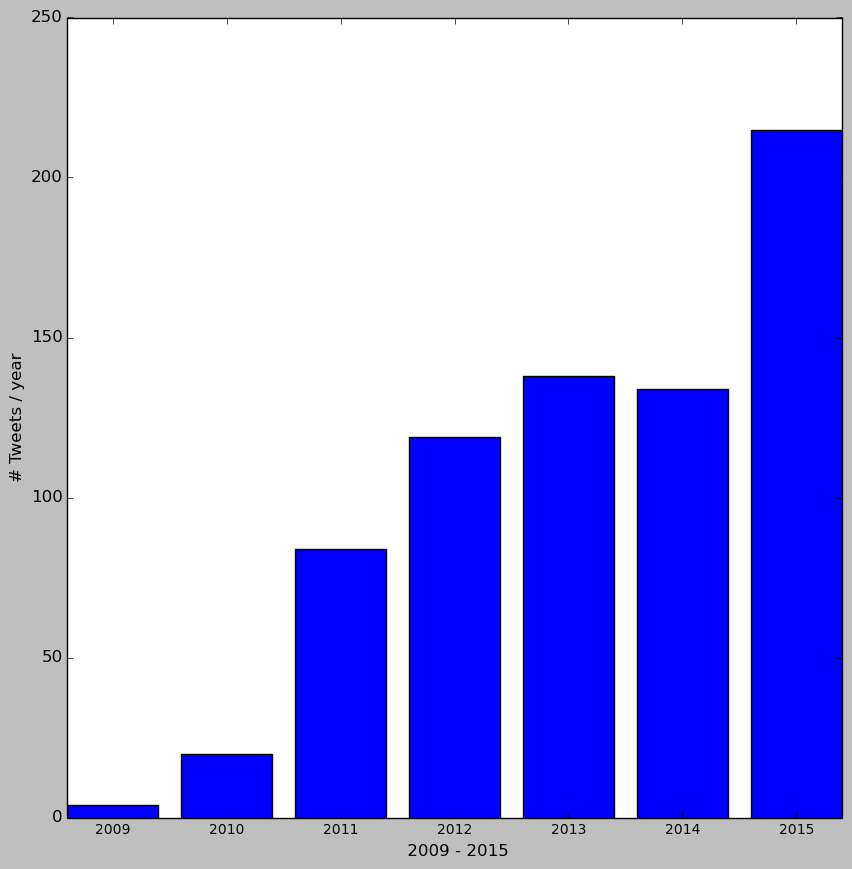

In [8]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x,y = zip(*year_count)
plt.figure(figsize=(10,10), dpi=40)
plt.xlabel(" 2009 - 2015")
plt.ylabel("# Tweets / year")
plt.xticks(range(2008, 2016), range(2008, 2016), size='small')
plt.bar(x,y, align='center')
plt.show()

In [9]:
# 
testx1 = DATA_SCIENCE_tweets.map(lambda x: x[0])
#testx1.take(100)


In [10]:
#Truncate datetime to obtain number of "data science" -related tweets per day
#dt = mma_tweets.collect()[-1][0]
#dt = dt.replace(hour=0, minute=0, second=0, microsecond=0)
tweets_perday = DATA_SCIENCE_tweets.map(lambda x: x[0].replace(hour=0, minute=0, second=0, microsecond=0))
#tweets_perday.count()
tweets_perday_2013_end = tweets_perday.filter(lambda x: (x.year > 2012))
tweets_perday_2013 = tweets_perday_2013_end.filter(lambda x: (x.year < 2014))
tweets_perday_2013 = tweets_perday_2013.map(lambda x: (x,1)).reduceByKey(add).sortByKey()
#tweets_perday1.count()
tweets_perday_2013.take(7)
# type is pipelinedRDD

[(datetime.datetime(2013, 1, 1, 0, 0), 1),
 (datetime.datetime(2013, 1, 7, 0, 0), 1),
 (datetime.datetime(2013, 1, 22, 0, 0), 1),
 (datetime.datetime(2013, 1, 25, 0, 0), 1),
 (datetime.datetime(2013, 2, 4, 0, 0), 1),
 (datetime.datetime(2013, 2, 11, 0, 0), 1),
 (datetime.datetime(2013, 2, 25, 0, 0), 1)]

In [11]:
from datetime import date, timedelta

def perdelta(start, end, delta):
    curr = start
    datelist=[]
    while curr < end:
        #yield curr
        curr += delta
        datelist.append((curr,0))
    return datelist

list2013 = perdelta(dt(2012, 12, 31), dt(2013, 12, 31), timedelta(days=1))
RDD2013 = sc.parallelize(list2013)

tweets_perAllDay_2013 = RDD2013.union(tweets_perday_2013)
tweets_perAllDay_2013_ = tweets_perAllDay_2013.map(lambda x: (x[0],x[1])).reduceByKey(add).sortByKey()

tweets_DS_2013 = tweets_perAllDay_2013_.collect()
tweets_DS_2013[0]

#test = map(list, zip(*tweets_DS_2013))
#import numpy as np
#tester = np.array(tweets_DS_2013).T.tolist()
#tester[1]
#test[1]
#array(tweets_DS_2013)

(datetime.datetime(2013, 1, 1, 0, 0), 1)

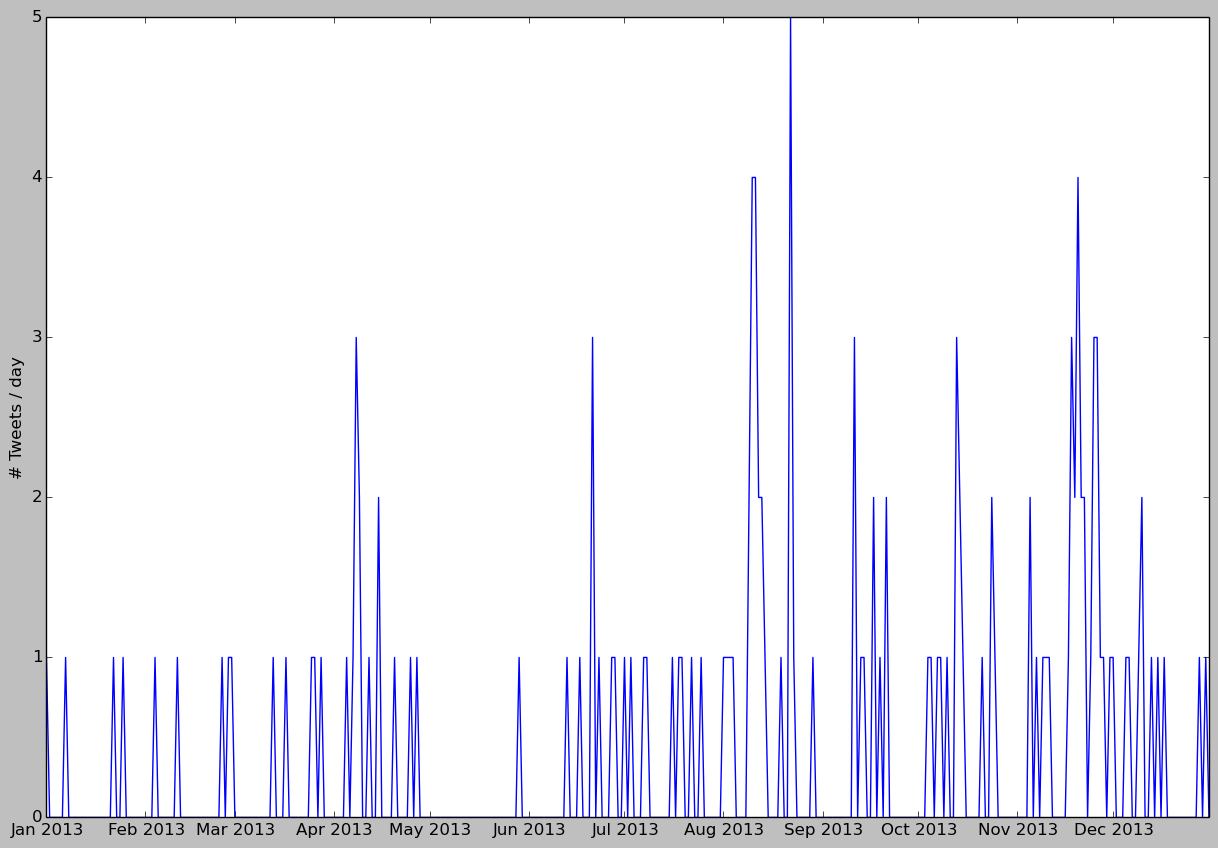

In [12]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

x,y = zip(*tweets_DS_2013)
plt.figure(figsize=(15,10), dpi=400)
plt.ylabel("# Tweets / day")
plt.plot(x,y)
plt.show()


In [24]:
import numpy as np
def estimate_response(stimulus, response):
    """
    EXPLAIN HERE
    PUT REFERENCES
    WHAT ARE YOUR VARIABLES? 
    """
    n_fir = 5 #response model order
    time_vector_length = len(stimulus)
    observation_matrix = np.zeros(shape=(time_vector_length, n_fir + 1))

    for idx in range(0, n_fir+1):
        updated_column  = [0]*idx + stimulus[0: time_vector_length - idx]
        observation_matrix[:, idx] =  updated_column
        
    print observation_matrix
    estimated_impulse_response = np.dot(np.linalg.pinv(observation_matrix), response)
    return estimated_impulse_response


#test estimate response....
stimulus = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
response = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]

print estimate_response(stimulus, response)

[[  1.   0.   0.   0.   0.   0.]
 [  2.   1.   0.   0.   0.   0.]
 [  3.   2.   1.   0.   0.   0.]
 [  4.   3.   2.   1.   0.   0.]
 [  5.   4.   3.   2.   1.   0.]
 [  6.   5.   4.   3.   2.   1.]
 [  7.   6.   5.   4.   3.   2.]
 [  8.   7.   6.   5.   4.   3.]
 [  9.   8.   7.   6.   5.   4.]
 [ 10.   9.   8.   7.   6.   5.]
 [ 11.  10.   9.   8.   7.   6.]
 [ 12.  11.  10.   9.   8.   7.]
 [ 13.  12.  11.  10.   9.   8.]
 [ 14.  13.  12.  11.  10.   9.]
 [ 15.  14.  13.  12.  11.  10.]
 [ 16.  15.  14.  13.  12.  11.]]
[  2.00000000e+00  -3.00076634e-14   1.56862057e-14   3.97000954e-16
  -1.80237769e-15   6.27969898e-16]
